In [1]:
import os
import json
import shutil
import tempfile
import time
from typing import Tuple
import glob

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Activations,
    ScaleIntensityRanged,
    EnsureChannelFirstd,
    Orientationd,
    ScaleIntensityRange,
    RandCropByPosNegLabeld,
    Compose
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, UNet

from monai import data
from monai.data import decollate_batch, DataLoader, Dataset
from functools import partial

import torch
import torch.optim as optim
import torch.nn as nn

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

from sklearn.model_selection import train_test_split

In [2]:
model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
).to("cuda")
# load
state = torch.load('model/cleanSlidingWindowCorrected/checkpoint copy.pt')

In [3]:
def recursive_removal_module(input_dict):
    newdict = {}
    for key in input_dict.keys():
        newKey = key[7:]
        if isinstance(input_dict[key], dict):
            newdict[newKey] = recursive_removal_module(input_dict[key])
        else:
            newdict[newKey] = input_dict[key]
    return newdict

In [4]:
normal_state = recursive_removal_module(state)

In [5]:
# load
model.load_state_dict(normal_state)

<All keys matched successfully>

In [6]:
def get_loader(batch_size, data_dir, roi):
    """
    Provide data loader for training and validation data.
    """
    images = sorted(glob.glob(os.path.join(data_dir, "volume", "*.nii.gz")))
    segs = sorted(glob.glob(os.path.join(data_dir, "seg", "*.nii.gz")))

    data_dicts = [
        {"image": image_name, "label": seg_name}
        for image_name, seg_name in zip(images, segs)
    ]
    data_dicts = data_dicts[:20] # Limit data to test the pipeline

    train_files, val_files = train_test_split(data_dicts, train_size=0.8, random_state=0)

    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            # Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            # Probably not needed 
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(roi[0], roi[1], roi[2]),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-1024,
                a_max=3071,
                b_min=0.0,
                b_max=1.0,
                clip=True),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image"
            ),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            # Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            # Probably not needed 
            ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=3071, b_min=0.0, b_max=1.0, clip=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)
    val_ds = data.Dataset(data=val_files, transform=val_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=6,
        pin_memory=True,
    )

    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=6,
        pin_memory=True,
    )

    return train_loader, val_loader

In [7]:
metric = DiceMetric(include_background=False, reduction=MetricReduction.MEAN)
roi = (128, 128, 64)

In [8]:
_, val_data = get_loader(1, "/tsi/data_education/data_challenge/train", roi)

/home/ids/ext-2297/miniconda3/envs/pscc/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [9]:
len(val_data)

4

Shape of inputs before post pred:  torch.Size([1, 1, 441, 355, 110])
Shape of labels before post pred:  torch.Size([1, 1, 441, 355, 110])
Metric shape:  torch.Size([1, 1])
Metric value:  metatensor([[0.6553]], device='cuda:0')


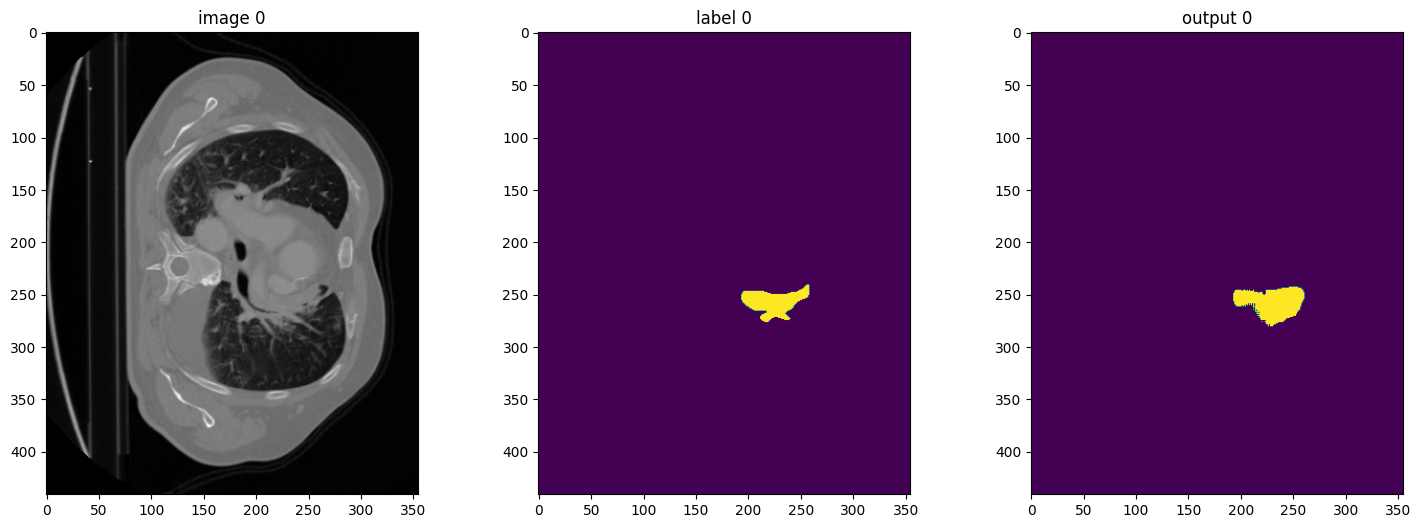

Shape of inputs before post pred:  torch.Size([1, 1, 422, 371, 111])
Shape of labels before post pred:  torch.Size([1, 1, 422, 371, 111])
Metric shape:  torch.Size([1, 1])
Metric value:  metatensor([[0.7822]], device='cuda:0')


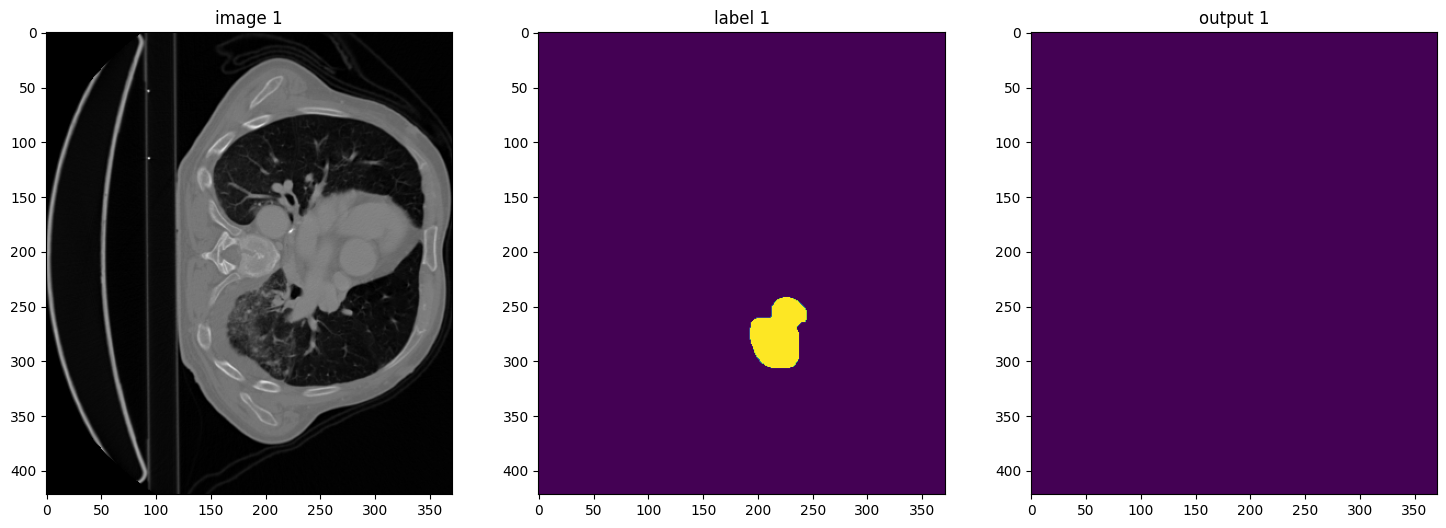

Shape of inputs before post pred:  torch.Size([1, 1, 408, 372, 102])
Shape of labels before post pred:  torch.Size([1, 1, 408, 372, 102])
Metric shape:  torch.Size([1, 1])
Metric value:  metatensor([[0.6779]], device='cuda:0')


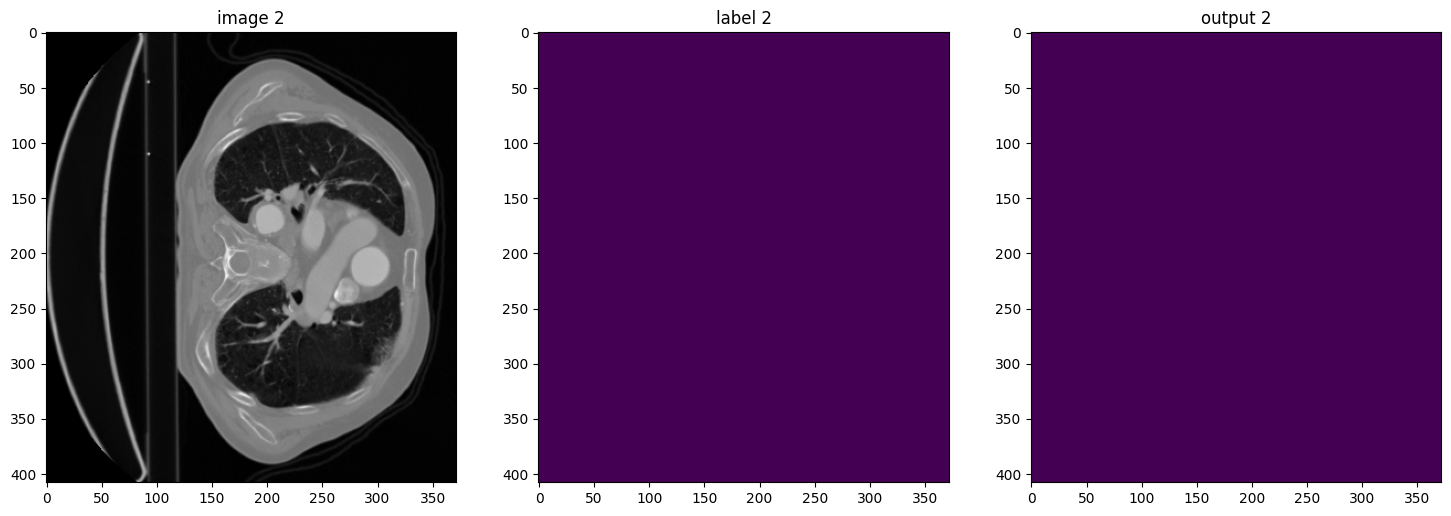

Shape of inputs before post pred:  torch.Size([1, 1, 444, 352, 91])
Shape of labels before post pred:  torch.Size([1, 1, 444, 352, 91])
Metric shape:  torch.Size([1, 1])
Metric value:  metatensor([[0.]], device='cuda:0')


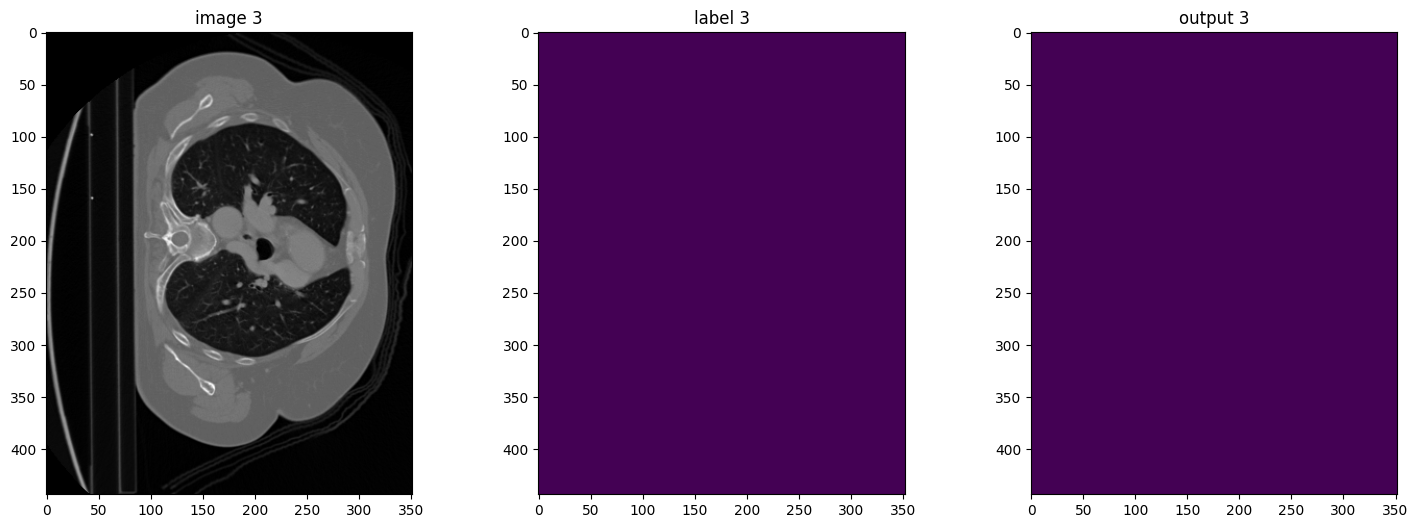

In [24]:
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
mean_metric_history = []
model.eval()
with torch.no_grad():
    for i, batch_data in enumerate(val_data):
        inputs, labels = (
            batch_data["image"].to(0),
            batch_data["label"].to(0),
        )
        print("Shape of inputs before post pred: ", inputs.shape)
        print("Shape of labels before post pred: ", labels.shape)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            inputs, roi, sw_batch_size, model
        )
        val_outputs_post = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(labels)]
        # val_outputs = torch.cat(val_outputs)
        # val_labels = torch.cat(val_labels)
        # print("Shape of inputs after post pred: ", val_outputs.shape)
        # print("Shape of labels after post pred: ", val_labels.shape)
        
        metric_value = metric(y_pred=val_outputs_post, y=val_labels)
        print("Metric shape: ", metric_value.shape)
        print("Metric value: ", metric_value)

        heigth = 50

        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(inputs[0, 0, :, :, heigth].cpu().detach(), cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(labels[0, 0, :, :, heigth].cpu().detach())
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).cpu().detach()[0, :, :, heigth])
        plt.show()
    
    # Aggregate the final mean metric value
    value_metric = metric.aggregate().item()
    mean_metric_history.append(value_metric)
    metric.reset()


torch.Size([2, 441, 355, 110])

In [11]:
mean_metric_history

[0.0]